## Data Visualization of climate data

<xarray.Dataset> Size: 49MB
Dimensions:     (valid_time: 96, latitude: 116, longitude: 138)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 768B 2017-01-01 ... 2024-12-01
  * latitude    (latitude) float64 928B 61.0 60.9 60.8 60.7 ... 49.7 49.6 49.5
  * longitude   (longitude) float64 1kB -11.0 -10.9 -10.8 -10.7 ... 2.5 2.6 2.7
    expver      (valid_time) <U4 2kB ...
Data variables:
    d2m         (valid_time, latitude, longitude) float32 6MB ...
    t2m         (valid_time, latitude, longitude) float32 6MB ...
    src         (valid_time, latitude, longitude) float32 6MB ...
    slhf        (valid_time, latitude, longitude) float32 6MB ...
    sp          (valid_time, latitude, longitude) float32 6MB ...
    tp          (valid_time, latitude, longitude) float32 6MB ...
    lai_hv      (valid_time, latitude, longitude) float32 6MB ...
    lai_lv      (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
 

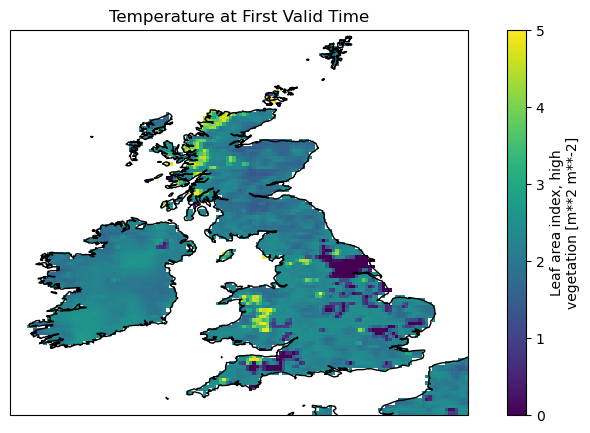

In [1]:
# visualise the data
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# load the data
data = xr.open_dataset("data/era5_data.nc")
print(data)

# Select the first time step using 'valid_time'
data_at_first_time = data.isel(valid_time=0)

# Plot the data
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
data_at_first_time["lai_hv"].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Temperature at First Valid Time')
plt.show()

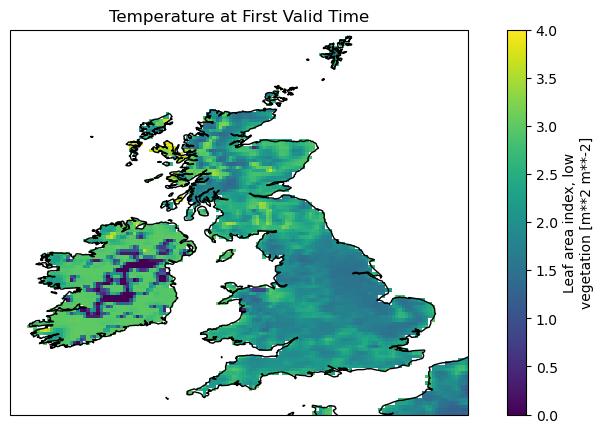

In [2]:
# Plot the data
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
data_at_first_time["lai_lv"].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Temperature at First Valid Time')
plt.show()

## Name Fixing of LTLA names

In [8]:
# import geopandas as gpd
# #https://raw.githubusercontent.com/ONSvisual/uk-topojson/refs/heads/main/output/topo.json
# # converted to GEOJSON with https://mygeodata.cloud/conversion#vector
# name_fix_mapping = {
#     "Bournemouth, Christchurch and Poole": "Bournemouth",
#     "Bristol, City of": "Bristol",
#     "Buckinghamshire": "Buckinghamshire UA",
#     "Folkestone and Hythe": "Folkestone & Hythe",
#     "Herefordshire, County of": "Herefordshire",
#     "Kingston upon Hull, City of": "Kingston upon Hull",
#     "North Yorkshire": "North Yorkshire UA",
#     "Somerset": "Somerset UA",
# }

# gdf = gpd.read_file("/home/hbz15/HFC-Lyme-Disease/submission/data/ltla.geojson")
# gdf["areanm"] = gdf["areanm"].replace(name_fix_mapping)
# # save the data again 
# gdf.to_file("/home/hbz15/HFC-Lyme-Disease/submission/data/ltla.geojson", driver="GeoJSON")



## Climate data ERA5 processing

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import logging

logging.basicConfig(level=logging.INFO)

def process_county(ds, county, counties_crs):
    county_id = county['areanm']
    geom = county.geometry

    if county_id == "Gosport":
        # Chosen lat/lon that is inside Gosport on land (example, decimal degrees)
        gosport_lon, gosport_lat = -1.2, 50.85
        county_ds = ds.sel(longitude=gosport_lon, latitude=gosport_lat, method="nearest")
    else:
        try:
            county_ds = ds.rio.clip([geom], counties_crs, drop=True, all_touched=True)
            if county_ds['t2m'].size == 0:
                raise ValueError("No data found in clipped dataset")
        except Exception as e:
            logging.warning(f"Could not clip county {county_id}: {e}. Using nearest grid cell fallback.")
            centroid = geom.centroid
            nearest_lon = float(ds.longitude.sel(longitude=centroid.x, method="nearest"))
            nearest_lat = float(ds.latitude.sel(latitude=centroid.y, method="nearest"))
            county_ds = ds.sel(longitude=nearest_lon, latitude=nearest_lat, method="nearest")
    
    print(county_ds, county_id)
    
    if all(dim in county_ds['t2m'].dims for dim in ["latitude", "longitude"]):
        temp_mean = county_ds['t2m'].mean(dim=["latitude", "longitude"])
        q_mean = county_ds['q2m'].mean(dim=["latitude", "longitude"])
        rh_mean = county_ds['rh2m'].mean(dim=["latitude", "longitude"])
        src_mean = county_ds['src'].mean(dim=["latitude", "longitude"])
        sp_mean = county_ds['sp'].mean(dim=["latitude", "longitude"])
        tp_mean = county_ds['tp'].mean(dim=["latitude", "longitude"])
        lai_hv_mean = county_ds['lai_hv'].mean(dim=["latitude", "longitude"])
        lai_lv_mean = county_ds['lai_lv'].mean(dim=["latitude", "longitude"])
    else:
        temp_mean = county_ds['t2m']
        q_mean = county_ds['q2m']
        rh_mean = county_ds['rh2m']
        src_mean = county_ds['src']
        sp_mean = county_ds['sp']
        tp_mean = county_ds['tp']
        lai_hv_mean = county_ds['lai_hv']
        lai_lv_mean = county_ds['lai_lv']
    
    return temp_mean, q_mean, rh_mean, src_mean, sp_mean, tp_mean, lai_hv_mean, lai_lv_mean

# Loop over desired years
# for year in [17, 18, 19, 20, 21, 22]:
# for year in [23, 24]:
ds = xr.open_dataset('data/era5_data.nc')
ds = ds.rio.write_crs("EPSG:4326")

# Uncomment interpolation if needed for higher resolution
# new_lon = np.arange(-11, 2.7, 0.005)
# new_lat = np.arange(49.5, 61, 0.005)
# ds = ds.interp(longitude=new_lon, latitude=new_lat, method="linear")

county_name = "areanm"
forecast_counties = pd.read_csv("forecast.csv")
counties = gpd.read_file("data/ltla.geojson")
counties = counties[counties[county_name].isin(forecast_counties['Council'].unique())]
counties = counties.drop_duplicates(subset=[county_name])

missing_counties = forecast_counties[~forecast_counties['Council'].isin(counties[county_name])]
logging.info(f"Missing counties: {missing_counties['Council'].unique()}")

# assert forecast_counties['Council'].nunique() == len(counties), (
#     f"Mismatch between forecast and county data ({forecast_counties['Council'].nunique()} vs {len(counties)})"
# )

# Fix invalid geometries and reproject if needed
counties['geometry'] = counties['geometry'].buffer(0)
if counties.crs != 'EPSG:4326':
    counties = counties.to_crs('EPSG:4326')

logging.info(f"Counties CRS: {counties.crs}")
logging.info(f"Dataset CRS: {ds.rio.crs}")
logging.info(f"Longitude resolution: {np.diff(ds.longitude.values)[0]} degrees")
logging.info(f"Latitude resolution: {np.diff(ds.latitude.values)[0]} degrees")
logging.info(f"NetCDF bounds: {ds.rio.bounds()}")

# Convert temperature and dewpoint from Kelvin to Celsius
ds['t2m_c'] = ds['t2m'] - 273.15
ds['d2m_c'] = ds['d2m'] - 273.15

def calculate_specific_humidity(dewpoint, pressure):
    e = 6.1078 * 10 ** ((7.5 * dewpoint) / (237.3 + dewpoint))
    return 0.622 * e / (pressure / 100 - 0.378 * e)

def calculate_relative_humidity(temp, dewpoint):
    es = 6.1078 * 10 ** ((7.5 * temp) / (237.3 + temp))
    e = 6.1078 * 10 ** ((7.5 * dewpoint) / (237.3 + dewpoint))
    return (e / es) * 100

ds['q2m'] = calculate_specific_humidity(ds['d2m_c'], ds['sp'])
ds['rh2m'] = calculate_relative_humidity(ds['t2m_c'], ds['d2m_c'])

ds['valid_time'] = pd.to_datetime(ds['valid_time'].values)
ds = ds.assign_coords(year=('valid_time', ds['valid_time'].dt.year.data))

results = []
for idx, county in tqdm(counties.iterrows(), total=len(counties)):
    # skip Isles of Scilly
    if county['areanm'] == "Isles of Scilly":
        continue
    else:
        temp_mean, q_mean, rh_mean, src_mean, sp_mean, tp_mean, lai_hv_mean, lai_lv_mean = process_county(ds, county, counties.crs)
        
        if ds['t2m'].size == 0:
            logging.info(f"No data within county {county['areanm']}.")
            continue
        
        temp_by_month = temp_mean.resample(valid_time='1MS').mean()
        q_by_month = q_mean.resample(valid_time='1MS').mean()
        rh_by_month = rh_mean.resample(valid_time='1MS').mean()
        
        for timestamp in temp_by_month.valid_time.values:
            dt = pd.to_datetime(timestamp)
            results.append({
                'areanm': county['areanm'],
                'year': dt.year,
                'Month': dt.month,
                't2m': float(temp_by_month.sel(valid_time=timestamp).values),
                'spec_humidity': float(q_by_month.sel(valid_time=timestamp).values),
                'rel_humidity': float(rh_by_month.sel(valid_time=timestamp).values),
                'src': float(src_mean.sel(valid_time=timestamp).values),
                'sp': float(sp_mean.sel(valid_time=timestamp).values),
                'tp': float(tp_mean.sel(valid_time=timestamp).values),
                'lai_hv': float(lai_hv_mean.sel(valid_time=timestamp).values),
                'lai_lv': float(lai_lv_mean.sel(valid_time=timestamp).values),
            })

results_df = pd.DataFrame(results)

# set Isles of scilly values to Cornwall values 
cornwall_values = results_df[results_df['areanm'] == "Cornwall"].copy()
cornwall_values['areanm'] = "Isles of Scilly"
results_df = pd.concat([results_df, cornwall_values], ignore_index=True)

results_df.to_csv(f"data/processed_data/climate.csv", index=False)

# Pivot to stack monthly values as columns
results_df = results_df.pivot(index=['areanm', 'year'], 
                                columns='Month', 
                                values=['t2m', 'spec_humidity', 'rel_humidity', 'src', 'sp', 'tp', 'lai_hv', 'lai_lv'])
results_df.columns = [f"{var}_{month}" for var, month in results_df.columns]
results_df.reset_index(inplace=True)
results_df.to_csv(f"data/processed_data/climate_stacked.csv", index=False)




INFO:root:Missing counties: []
INFO:root:Counties CRS: EPSG:4326
INFO:root:Dataset CRS: EPSG:4326
INFO:root:Longitude resolution: 0.09999999999999964 degrees
INFO:root:Latitude resolution: -0.10000000000000142 degrees
INFO:root:NetCDF bounds: (-11.05, 49.45, 2.75, 61.05)


  0%|          | 0/296 [00:00<?, ?it/s]

<xarray.Dataset> Size: 31kB
Dimensions:      (valid_time: 96, latitude: 2, longitude: 3)
Coordinates:
    number       int64 8B ...
  * valid_time   (valid_time) datetime64[ns] 768B 2017-01-01 ... 2024-12-01
  * latitude     (latitude) float64 16B 54.7 54.6
  * longitude    (longitude) float64 24B -1.4 -1.3 -1.2
    expver       (valid_time) <U4 2kB ...
    year         (valid_time) int64 768B 2017 2017 2017 2017 ... 2024 2024 2024
    spatial_ref  int64 8B 0
Data variables:
    d2m          (valid_time, latitude, longitude) float32 2kB nan ... 278.0
    t2m          (valid_time, latitude, longitude) float32 2kB nan ... 280.7
    src          (valid_time, latitude, longitude) float32 2kB nan ... 0.000129
    slhf         (valid_time, latitude, longitude) float32 2kB nan ... -2.038...
    sp           (valid_time, latitude, longitude) float32 2kB nan ... 1.015e+05
    tp           (valid_time, latitude, longitude) float32 2kB nan ... 0.002717
    lai_hv       (valid_time, latitude, long

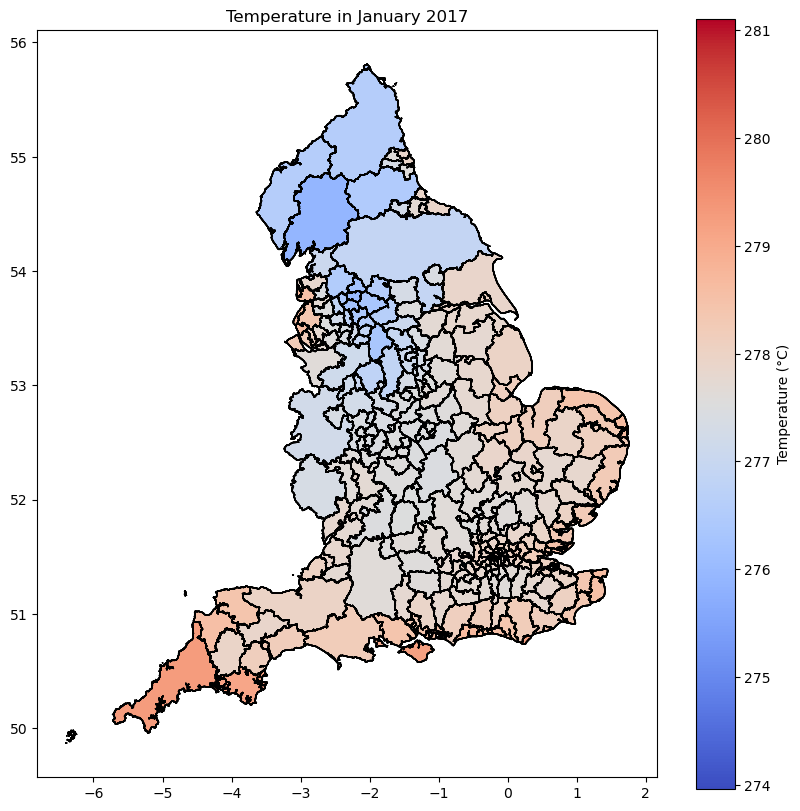

In [16]:
# plot climate_17.csv for each areanm. Only plot month=1. Plot with geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
df_plot = pd.read_csv("data/processed_data/climate_17.csv")
df_plot = df_plot[df_plot['Month'] == 1]

counties = gpd.read_file("data/ltla.geojson")
counties = counties[counties['areanm'].isin(df_plot['areanm'].unique())]
counties = counties.drop_duplicates(subset=['areanm'])
counties = counties.merge(df_plot, on='areanm', how='left') 

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
counties.boundary.plot(ax=ax, linewidth=1, color='black')
counties.plot(column='t2m', ax=ax, legend=True, cmap='coolwarm', legend_kwds={'label': "Temperature (°C)"})
plt.title('Temperature in January 2017')
plt.show()

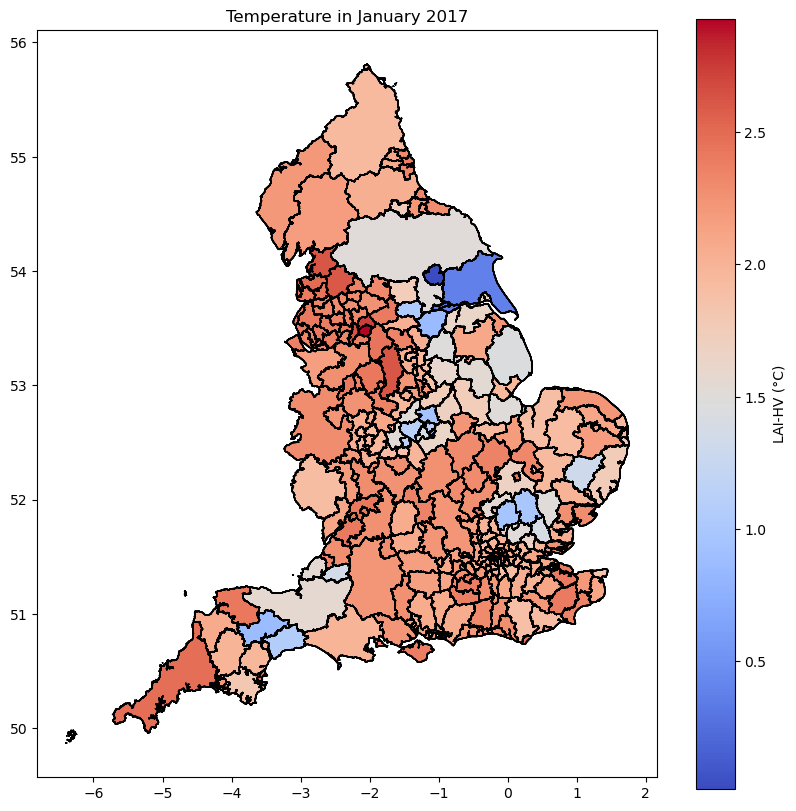

In [18]:
# plot climate_17.csv for each areanm. Only plot month=1. Plot with geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
df_plot = pd.read_csv("data/processed_data/climate_17.csv")
df_plot = df_plot[df_plot['Month'] == 1]

counties = gpd.read_file("data/ltla.geojson")
counties = counties[counties['areanm'].isin(df_plot['areanm'].unique())]
counties = counties.drop_duplicates(subset=['areanm'])
counties = counties.merge(df_plot, on='areanm', how='left') 

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
counties.boundary.plot(ax=ax, linewidth=1, color='black')
counties.plot(column='lai_hv', ax=ax, legend=True, cmap='coolwarm', legend_kwds={'label': "LAI-HV (°C)"})
plt.title('Temperature in January 2017')
plt.show()

## Cropland Processing

In [ ]:
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# === Load Copernicus land cover GeoTIFF ===
# https://lcviewer.vito.be/download
# https://land.copernicus.eu/en/products/global-dynamic-land-cover/copernicus-global-land-service-land-cover-100m-collection-3-epoch-2019-globe
landcover = rioxarray.open_rasterio("data/W020N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Tree-CoverFraction-layer_EPSG-4326.tif", masked=True).squeeze()
landcover2 = rioxarray.open_rasterio("data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Tree-CoverFraction-layer_EPSG-4326.tif", masked=True).squeeze()
# merge the 2 rasters
landcover = xr.concat([landcover, landcover2], dim="x")

landcover = landcover.rio.write_crs("EPSG:4326")
# landcover
# slice out extend of UK from landcover
landcover = landcover.sel(
    x=slice(-11, 2.7),
    y=slice(61, 49.5)
)

print(f"Landcover CRS: {landcover.rio.crs}")
print(f"Landcover shape: {landcover.shape}")
print(f"Landcover bounds: {landcover.rio.bounds()}")

# Load counties and ensure correct CRS
year = 24
county_name = "areanm"
forecast_counties = pd.read_csv("forecast.csv")
forecast_counties = forecast_counties[forecast_counties["Year"] == 2000 + year]
counties = gpd.read_file("data/ltla.geojson")
counties = counties[counties[county_name].isin(forecast_counties['Council'].unique())]
counties = counties.drop_duplicates(subset=[county_name])

# Print missing counties
missing_counties = forecast_counties[~forecast_counties['Council'].isin(counties[county_name])]
print(f"Missing counties: {missing_counties['Council'].unique()}")

assert forecast_counties['Council'].nunique() == len(counties), (
    f"Mismatch between forecast and county data ({forecast_counties['Council'].nunique()} vs {len(counties)})"
)

if counties.crs != 'EPSG:4326':
    counties = counties.to_crs('EPSG:4326')

# Ensure CRS match
counties = counties.to_crs(landcover.rio.crs)

# === Analyze per county ===
results = []

for _, row in tqdm(counties.iterrows(), total=len(counties)):
    name = row[county_name]
    geom = row.geometry

    # Clip raster to this county
    clipped = landcover.rio.clip([geom], counties.crs, drop=True, invert=False)

    # Get pixel values inside county
    vals = clipped.values.flatten()
    vals = vals[~np.isnan(vals)]

    if len(vals) == 0:
        print(f"No values found for {name}")
        continue

    # Count land cover classes
    unique, counts = np.unique(vals.astype(int), return_counts=True)
    lc_dist = dict(zip(unique, counts))

    results.append({
        "areanm": name,
        "total_pixels": len(vals),
        **lc_dist
    })




Landcover CRS: EPSG:4326
Landcover shape: (10584, 13810)
Landcover bounds: (-11.00000000000003, 49.500000000000036, 2.7003968253968162, 60.0)
Missing counties: []


  0%|          | 0/296 [00:00<?, ?it/s]

In [7]:
# Convert results to DataFrame
df_lc = pd.DataFrame(results)

# Identify valid tree cover columns (0–100, skip metadata)
tree_cover_cols = [c for c in df_lc.columns[2:]]

# Fill NaNs with 0 for calculation purposes
df_lc_filled = df_lc[tree_cover_cols].fillna(0)

# 1. Mean tree cover (%), ignoring NaNs
weighted_sum = sum(c * df_lc_filled[c] for c in tree_cover_cols)
df_lc["mean_tree_cover_pct"] = weighted_sum / df_lc["total_pixels"]

# 2. Proportion of county with tree cover ≥ threshold
threshold = 30
wooded_sum = sum(df_lc_filled[c] for c in tree_cover_cols if c >= threshold)
df_lc["pct_wooded"] = wooded_sum / df_lc["total_pixels"]

# Optional: Normalize each class to % area
for col in tree_cover_cols:
    df_lc[f"{col}_pct"] = df_lc_filled[col] / df_lc["total_pixels"]

# Set county name as index
df_lc.set_index("county", inplace=True)

# Preview
print(df_lc[["mean_tree_cover_pct", "pct_wooded"]].head())
df_lc[["mean_tree_cover_pct", "pct_wooded"]].to_csv(f"data/processed_data/landcover_2019.csv")

                      mean_tree_cover_pct  pct_wooded
county                                               
Hartlepool                       6.002336    0.022159
Middlesbrough                    5.067670    0.014921
Redcar and Cleveland            11.635389    0.092409
Stockton-on-Tees                 6.534725    0.031287
Darlington                       6.031938    0.016578


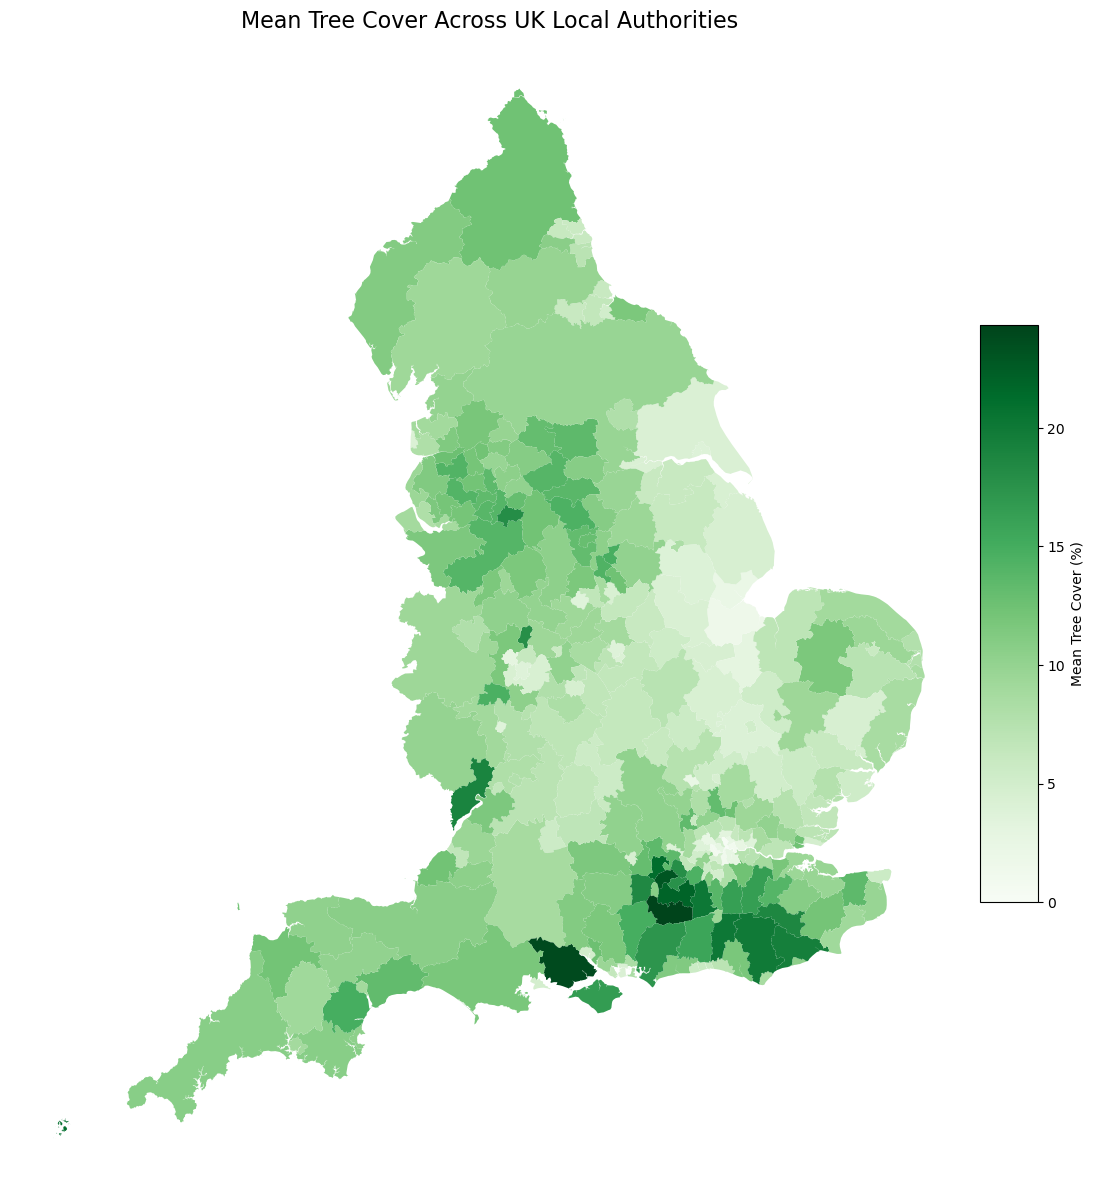

In [8]:
# plot pct_wooded 
import pandas as pd
import os
os.environ["PROJ_DATA"] = "/path/to/miniconda3/envs/hfc_lyme/share/proj"
import geopandas as gpd
import matplotlib.pyplot as plt

# forecast 
forecast = pd.read_csv("forecast.csv")

# === Load tree cover index per county (computed earlier) ===
# df_lc.reset_index(inplace=True)  # Ensure 'county' is a column, not index
df_lc = df_lc.reset_index()
df_lc.rename(columns={"county": "areanm"}, inplace=True)

# === Load LAD boundaries ===
geojson_url = "data/ltla.geojson"
gdf = gpd.read_file(geojson_url)
# ensure unique areanm 
gdf = gdf.drop_duplicates(subset=["areanm"])
gdf = gdf[["areanm", "geometry"]]

# === Merge tree cover with GeoDataFrame ===
# Ensure consistent casing/spacing if needed
gdf_merged = gdf.merge(df_lc, on="areanm", how='left')
gdf_merged = gdf_merged[gdf_merged.areanm.isin(forecast.Council)]

# === Plot mean_tree_cover_pct ===
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf_merged.plot(
    column='mean_tree_cover_pct',
    ax=ax,
    legend=True,
    cmap='Greens',
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    legend_kwds={
        'label': "Mean Tree Cover (%)",
        'orientation': "vertical",
        'shrink': 0.5,
        'pad': 0.01,
        'aspect': 10
    }
)

ax.set_title("Mean Tree Cover Across UK Local Authorities", fontsize=16)
ax.set_axis_off()

# plt.savefig("mean_tree_cover_map.png", dpi=300, bbox_inches='tight')
# plt.show()


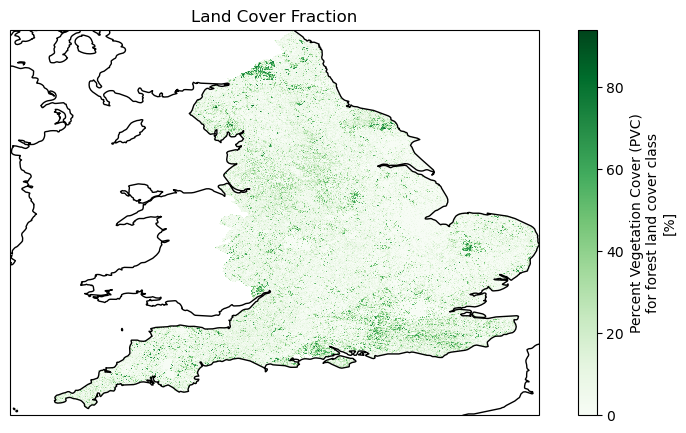

In [ ]:
# plot extent of landcover. Make a rectangle and plot 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
landcover.rio.clip(counties.geometry, counties.crs, drop=True, invert=False).plot(
    cmap='Greens',
)
# landcover.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=100)
ax.coastlines()
plt.title('Land Cover Fraction')
plt.show()

## Elevation

In [9]:
elevation = rioxarray.open_rasterio(
    "data/uk_srtm_dem_300m.tif",
    masked=True
).squeeze()

In [33]:
elevation

<xarray.DataArray (y: 4133, x: 4454)> Size: 74MB
[18408382 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 36kB -10.0 -9.997 -9.994 ... 1.996 1.998 2.001
  * y            (y) float64 33kB 60.14 60.13 60.13 60.13 ... 49.01 49.0 49.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      elevation

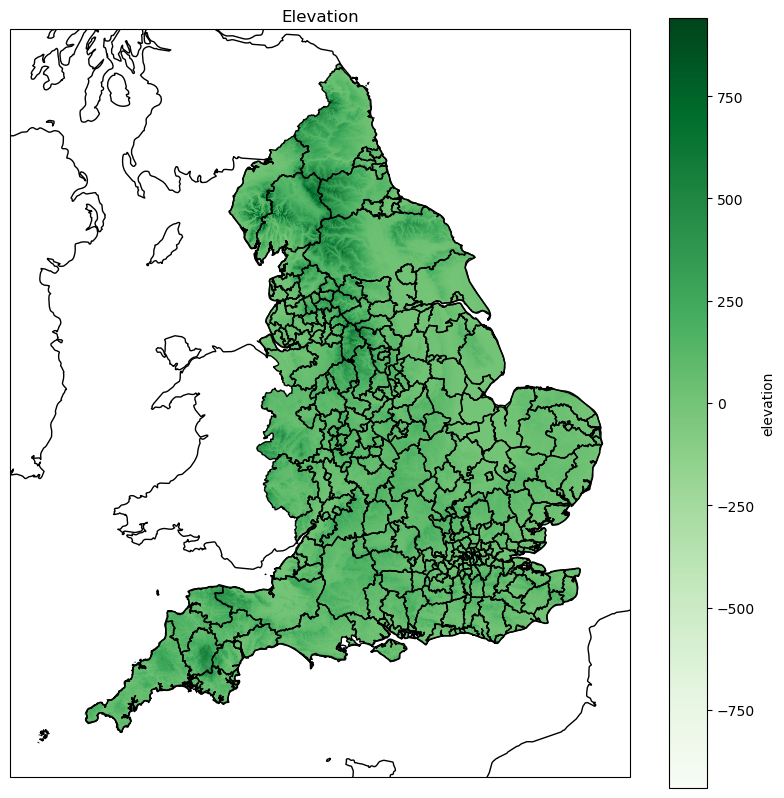

In [11]:
import os
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Set the PROJ_DATA environment variable (adjust the path as needed)
os.environ["PROJ_DATA"] = "/path/to/miniconda3/envs/hfc_lyme/share/proj"

# Load forecast data
forecast = pd.read_csv("forecast.csv")

# === Load LAD boundaries ===
geojson_path = "data/ltla.geojson"
gdf = gpd.read_file(geojson_path)

# Ensure unique entries for 'areanm' and keep only necessary columns
gdf = gdf.drop_duplicates(subset=["areanm"])[["areanm", "geometry"]]

# If the CRS is not defined, assign EPSG:4326
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")

# Filter GeoDataFrame to only include councils present in the forecast data
# (Ensure that the 'Council' column in forecast matches the format in gdf.areanm)
gdf = gdf[gdf.areanm.isin(forecast["Council"])]

# === Load elevation data ===
# Assuming 'elevation_meters.nc' is saved as a single-band raster
elevation = rioxarray.open_rasterio(
    "data/uk_srtm_dem_300m.tif",
    masked=True
).squeeze()

# === Plotting ===
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Clip the elevation data to the LAD boundaries
# Here, we use the geometry from gdf and its CRS
elev_clipped = elevation.rio.clip(gdf.geometry, gdf.crs, drop=True, invert=False)
elev_clipped.plot(ax=ax, cmap='Greens')

# Optionally, plot the LAD boundaries on top for reference
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add coastlines and other features
ax.coastlines()
plt.title('Elevation')
plt.show()

In [12]:

# Now compute average elevation for each areanm and save as csv (use clipping)
results = []

for idx, row in tqdm(gdf.iterrows(), total=len(gdf)):
    areanm = row["areanm"]
    geom = row["geometry"]

    # Clip the elevation data to the current geometry
    clipped = elevation.rio.clip([geom], gdf.crs, drop=True, invert=False)

    # Get pixel values inside geometry
    vals = clipped.values.flatten()
    vals = vals[~np.isnan(vals)]

    if len(vals) == 0:
        print(f"No values found for {areanm}")
        continue

    # Compute average elevation
    # avg_elev = np.mean(vals)
    avg_elev = np.median(vals)

    results.append({
        "areanm": areanm,
        "avg_elevation_m": avg_elev
    })

# Convert results to DataFrame
df_elev = pd.DataFrame(results)
df_elev.to_csv(f"data/processed_data/elevation.csv", index=False)

  0%|          | 0/296 [00:00<?, ?it/s]

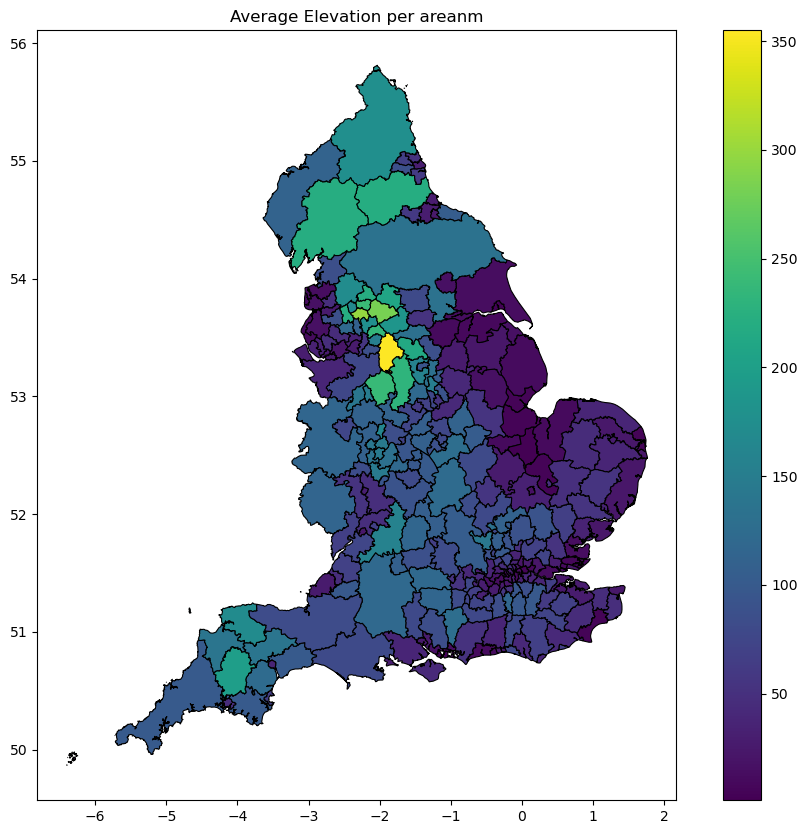

In [13]:
# Merge the computed elevation data with the GeoDataFrame
gdf_elev = gdf.merge(df_elev, on='areanm', how='left')

# 1. Choropleth Map of Average Elevation -------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_elev.plot(column='avg_elevation_m', cmap='viridis', linewidth=0.8,
              edgecolor='black', legend=True, ax=ax)
ax.set_title("Average Elevation per areanm")
plt.show()

## Tick Distribution

In [31]:
import pandas as pd 
import geopandas as gpd
import pandas as pd

# Load counties and ensure correct CRS
forecast = pd.read_csv("forecast.csv")
counties = gpd.read_file("data/ltla.geojson")
counties = counties[counties["areanm"].isin(forecast["Council"].unique())]
df = pd.read_csv("data/processed_data/vec_dyn_download_Mon Mar 24 2025 22_43_55 GMT+0100 (Central European Standard Time).csv")
df_atlas = pd.read_csv("data/processed_data/ixodes.csv")

In [32]:
df.shape, df_atlas.shape

((65, 50), (186, 4))

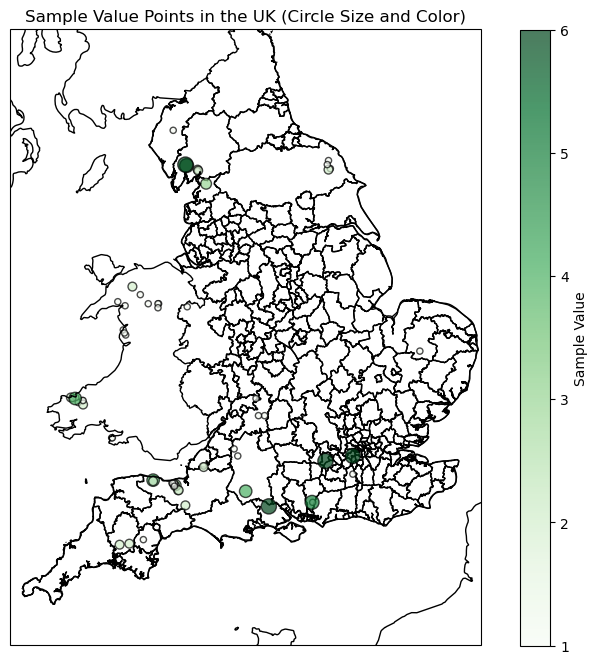

In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot UK boundaries
counties.plot(ax=ax, edgecolor='black', facecolor='none')

# Plot sample points with color and size
sc = ax.scatter(
    df["sample_long_dd"],
    df["sample_lat_dd"],
    c=df["sample_value"],        # color by value
    s=df["sample_value"] * 20,   # scale size by value
    cmap='Greens',
    alpha=0.7,
    edgecolors='black',
    transform=ccrs.PlateCarree()
)

# Add coastlines, borders, etc.
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([
    df["sample_long_dd"].min() - 1,
    df["sample_long_dd"].max() + 1,
    df["sample_lat_dd"].min() - 1,
    df["sample_lat_dd"].max() + 1
], crs=ccrs.PlateCarree())

# Colorbar for value
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='Sample Value')

plt.title("Sample Value Points in the UK (Circle Size and Color)")
plt.show()


Optimized kernel parameters: <gpflow.kernels.stationaries.SquaredExponential object at 0x7fcfffc346a0>


/tmp/ipykernel_1727504/2334966002.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['centroid'] = counties.geometry.centroid


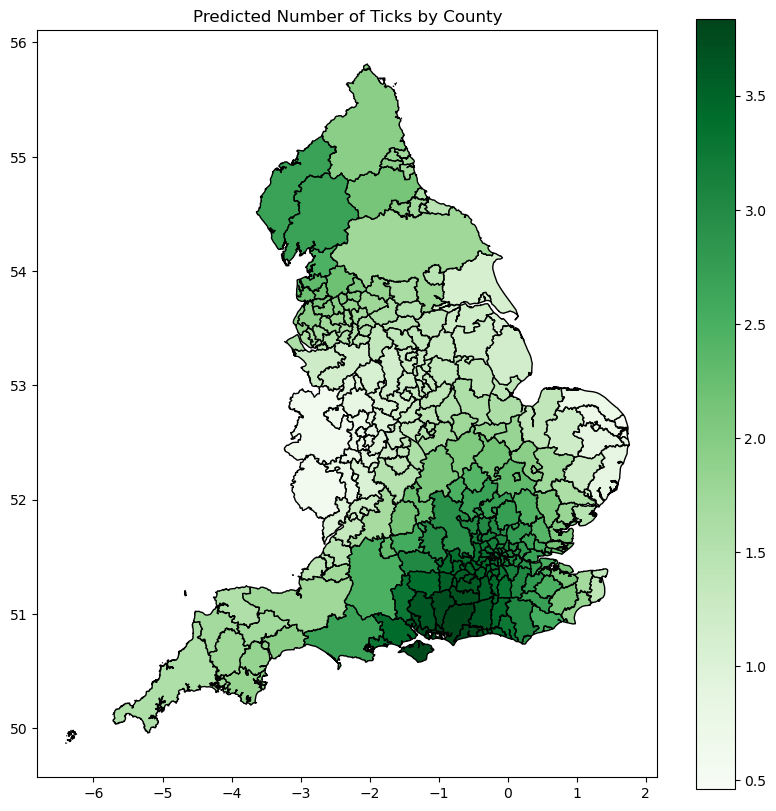

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import gpflow
import tensorflow as tf

# === Prepare Training Data from df ===
# Extract coordinates and tick counts
X = df[['sample_long_dd', 'sample_lat_dd']].values
y = df['sample_value'].values

# Standardize features (recommended for GP regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# GPFlow expects targets to be a 2D array
Y = y.reshape(-1, 1)

kernel = gpflow.kernels.RBF(lengthscales=1.0)

# Create the Gaussian Process regression model
model = gpflow.models.GPR(data=(X_scaled, Y), kernel=kernel, mean_function=None)

# Optimize hyperparameters (GPFlow automatically optimizes the kernel parameters)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables, options=dict(maxiter=100))
print("Optimized kernel parameters:", model.kernel)

# === Prepare County Centroids for Prediction ===
# Ensure counties is in the correct CRS (EPSG:4326)
if counties.crs is None:
    counties = counties.set_crs("EPSG:4326")

# Compute centroids of each county
counties['centroid'] = counties.geometry.centroid

# Extract centroid coordinates as an (n_counties x 2) array
county_coords = np.array([[pt.x, pt.y] for pt in counties['centroid']])

# Standardize county coordinates using the same scaler as training data
county_coords_scaled = scaler.transform(county_coords)

# === Predict Tick Counts at County Centroids using GPFlow ===
# GPFlow's predict_f returns both the mean and variance as TensorFlow tensors.
mean, var = model.predict_f(county_coords_scaled)
predictions = mean.numpy().flatten()          # convert tensor to numpy array
std_dev = np.sqrt(var.numpy().flatten())        # standard deviation is the square root of variance

# Add predictions to the counties GeoDataFrame
counties['tick_pred'] = predictions
counties['tick_std'] = std_dev

# === Plot the Predicted Tick Counts ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
counties.plot(column='tick_pred', ax=ax, legend=True, cmap='Greens', edgecolor='black')
ax.set_title("Predicted Number of Ticks by County")
plt.show()

# save the predictions to a csv file with the county name and the predicted value, and the standard deviation
counties[['areanm', 'tick_pred', 'tick_std']].to_csv("data/processed_data/tick_predictions.csv", index=False)

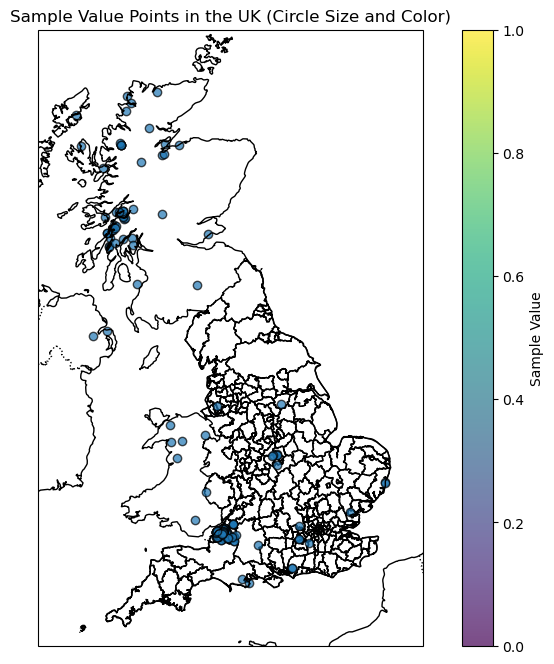

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot UK boundaries
counties.plot(ax=ax, edgecolor='black', facecolor='none')

# Plot sample points with color and size
sc = ax.scatter(
    df_atlas["longitude"],
    df_atlas["latitude"],
    alpha=0.7,
    edgecolors='black',
    transform=ccrs.PlateCarree()
)

# Add coastlines, borders, etc.
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([
    df_atlas["longitude"].min() - 1,
    df_atlas["longitude"].max() + 1,
    df_atlas["latitude"].min() - 1,
    df_atlas["latitude"].max() + 1
], crs=ccrs.PlateCarree())

# Colorbar for value
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='Sample Value')

plt.title("Sample Value Points in the UK (Circle Size and Color)")
plt.show()


## Host transmission

/tmp/ipykernel_518876/4249248800.py:197: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")


NameError: name 'np' is not defined

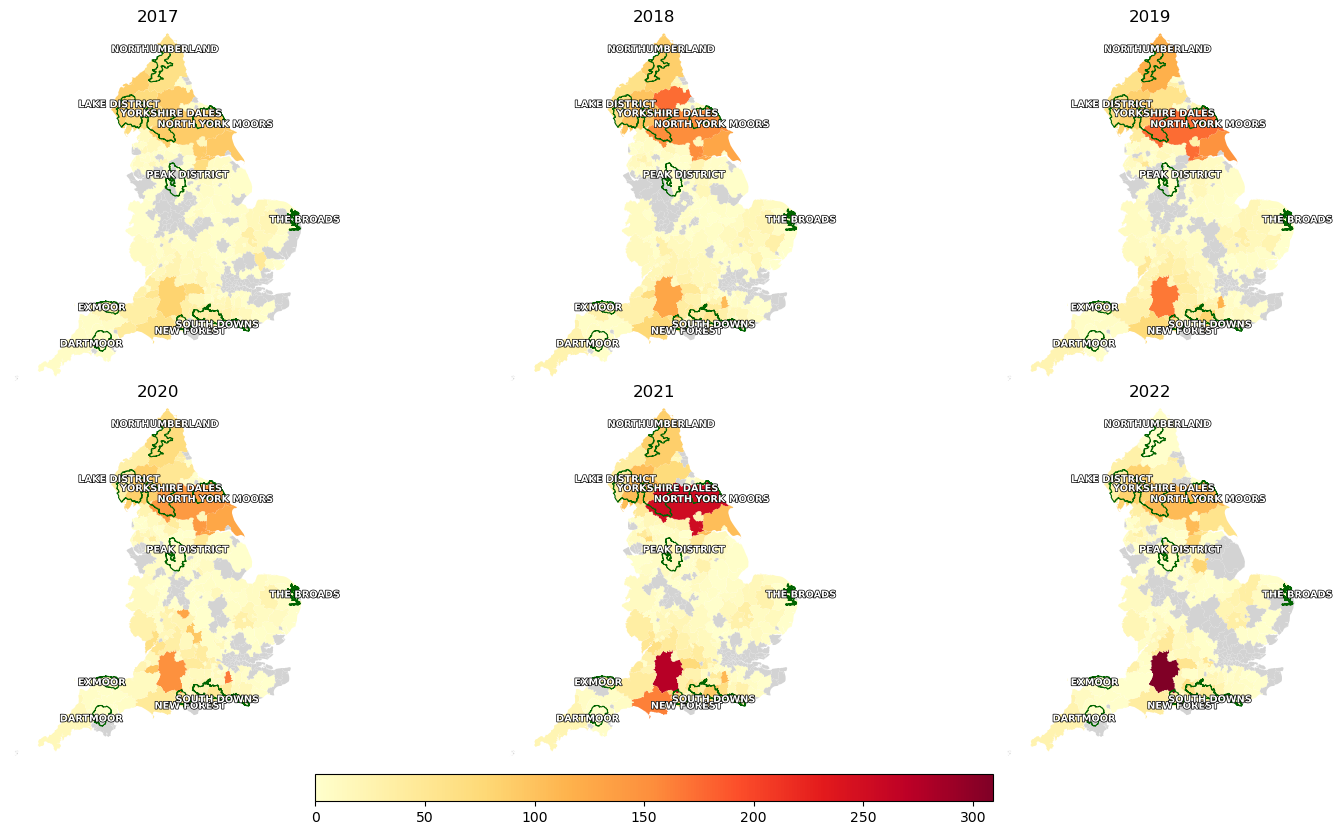

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Ensure PROJ_DATA is set if needed
os.environ["PROJ_DATA"] = "/path/to/miniconda3/envs/hfc_lyme/share/proj"

def get_host_counts(host, this_df_host, gdf_boundaries, year):
    """
    Given a DataFrame `this_df_host` (filtered to one year) with columns
    "Longitude (WGS84)" and "Latitude (WGS84)", plus a GeoDataFrame 
    `gdf_boundaries` (with “areanm” polygons in EPSG:4326), return a DataFrame
    ["areanm", "host_record_count", "year"].
    """
    if this_df_host.empty:
        return pd.DataFrame(columns=["areanm", f"{host}_record_count", "year"])

    # Ensure boundaries are in EPSG:4326
    gdf_boundaries = gdf_boundaries.to_crs("EPSG:4326")

    # Convert host‐points to a GeoDataFrame
    gdf_host_year = gpd.GeoDataFrame(
        this_df_host,
        geometry=gpd.points_from_xy(
            this_df_host["Longitude (WGS84)"],
            this_df_host["Latitude (WGS84)"]
        ),
        crs="EPSG:4326"
    )

    # Spatial join points → polygon “areanm”
    poly_simple = gdf_boundaries[["areanm", "geometry"]]
    joined = gpd.sjoin(
        gdf_host_year,
        poly_simple,
        how="left",
        predicate="within"
    )

    # Count points per areanm
    counts = (
        joined
        .groupby("areanm")
        .size()
        .reset_index(name=f"{host}_record_count")
    )
    counts["year"] = year
    return counts


hosts = [
    "roe_deer",
    "red_deer",
    "chinese_water_deer",
    "wood_mice",
    "bank_voles",
    "blackbird"
]

for host in hosts:

    # 1) Load host records
    df_host = pd.read_csv(
        f"/home/hbz15/lyme_disease_working/submission/data/transmission_host/{host}/records-2025-06-06.csv"
    )[["Longitude (WGS84)", "Latitude (WGS84)", "Start date"]].dropna()
    df_host["year"] = pd.to_datetime(df_host["Start date"]).dt.year

    # Restrict points to England‐bounding box
    df_host = df_host[
        (df_host["Longitude (WGS84)"] > -8) & (df_host["Longitude (WGS84)"] < 2) &
        (df_host["Latitude (WGS84)"] > 49) & (df_host["Latitude (WGS84)"] < 61)
    ]

    # 2) Load forecast list of councils
    forecast = pd.read_csv("../submission/forecast.csv")

    # 3) Load English LAD boundaries once
    gdf_boundaries = gpd.read_file("data/ltla.geojson")
    gdf_boundaries = gdf_boundaries[gdf_boundaries["areanm"].isin(forecast["Council"])]
    gdf_boundaries = gdf_boundaries.to_crs("EPSG:4326")

    # Compute bounding box + buffer to crop out Scotland
    minx, miny, maxx, maxy = gdf_boundaries.total_bounds
    buffer = 0.1
    xmin_plot, xmax_plot = minx - buffer, maxx + buffer
    ymin_plot, ymax_plot = miny - buffer, maxy + buffer

    # 4) Compute host counts for all years and stack into one DataFrame
    all_host_counts = []
    for yr in range(2017, 2023):
        this_year_hosts = df_host[df_host["year"] == yr].copy()
        counts = get_host_counts(host, this_year_hosts, gdf_boundaries, yr)
        all_host_counts.append(counts)
    host_summary_df = pd.concat(all_host_counts, ignore_index=True)

    # Find a reasonable vmax for the colormap (e.g. the 98th percentile or absolute max)
    vmax_host = int(host_summary_df[f"{host}_record_count"].max())
    vmin_host = 0

    # 5) Load parks & label offsets
    parks_gdf = gpd.read_file("data/National_Parks_England_4829975525583709119.geojson")
    parks_gdf = parks_gdf.to_crs("EPSG:4326")
    label_offsets = {
        "NORTHUMBERLAND":    ( 0.00,  0.25),
        "LAKE DISTRICT":     (-0.35,  0.12),
        "YORKSHIRE DALES":   ( 0.25,  0.18),
        "NORTH YORK MOORS":  ( 0.20, -0.12),
        "PEAK DISTRICT":     ( 0.25,  0.08),
        "EXMOOR":            (-0.30,  0.00),
        "DARTMOOR":          (-0.30, -0.05),
        "NEW FOREST":        ( 0.20, -0.12),
        "SOUTH DOWNS":       ( 0.25, -0.12),
        "THE BROADS":        ( 0.20,  0.00),
    }

    # 6) Create a 2×3 grid of subplots (one panel per year)
    years = list(range(2017, 2023))
    fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=False)
    fig.subplots_adjust(
        left=0.01,    # minimal left margin
        right=0.99,   # minimal right margin
        top=0.92,     # small top margin
        bottom=0.06,  # minimal bottom margin (for colorbar)
        wspace=0.04,  # tight column spacing
        hspace=0.04   # tight row spacing
    )

    for idx, year in enumerate(years):
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        # a) Extract host counts for this year
        this_counts = host_summary_df[host_summary_df["year"] == year]
        # b) Merge counts into the boundary GeoDataFrame
        gdf_merged = gdf_boundaries.merge(
            this_counts[["areanm", f"{host}_record_count"]],
            on="areanm",
            how="left"
        )

        # c) Plot host_count choropleth on this axis
        gdf_merged.plot(
            column=f"{host}_record_count",
            ax=ax,
            cmap="YlOrRd",
            vmin=vmin_host,
            vmax=vmax_host,
            missing_kwds={"color": "lightgrey"},
            legend=False
        )

        # d) Crop the view to England‐only
        ax.set_xlim(xmin_plot, xmax_plot)
        ax.set_ylim(ymin_plot, ymax_plot)

        # e) Overlay parks (boundaries + labels)
        parks_gdf.boundary.plot(
            ax=ax,
            edgecolor="darkgreen",
            linewidth=0.8
        )
        for _, park in parks_gdf.iterrows():
            name = park["NAME"]
            repr_pt = park.geometry.representative_point()
            x0, y0 = repr_pt.x, repr_pt.y
            dx, dy = label_offsets.get(name, (0.0, 0.0))
            x_text, y_text = x0 + dx, y0 + dy

            ax.annotate(
                text=name,
                xy=(x0, y0),
                xytext=(x_text, y_text),
                fontsize=7,
                fontweight="bold",
                color="white",
                ha="center",
                va="center",
                path_effects=[
                    pe.Stroke(linewidth=1.0, foreground="black"),
                    pe.Normal()
                ],
                arrowprops={
                    "arrowstyle": "-",
                    "lw": 0.6,
                    "color": "darkgreen",
                    "connectionstyle": "arc3,rad=0.0"
                }
            )

        # f) Title each panel by its year, then hide axes
        ax.set_title(f"{year}", fontsize=12, pad=4)
        ax.set_axis_off()

    # 7) Shared colorbar at bottom (host counts 0→vmax_host)
    cmap = plt.cm.get_cmap("YlOrRd")
    norm = plt.Normalize(vmin=vmin_host, vmax=vmax_host)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        orientation="horizontal",
        fraction=0.035,
        pad=0.015,
        aspect=25
    )
    # Choose tick locations at round numbers up to vmax_host
    ticks = list(np.linspace(0, vmax_host, num=6, dtype=int))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(t) for t in ticks])
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label(
        f"{host.replace('_', ' ').title()} Records per Area (2017–2022)",
        fontsize=10,
        labelpad=3
    )

    plt.suptitle(
        f"{host.replace('_', ' ').title()}: Host Counts by Local Authority (2017–2022)",
        fontsize=14,
        y=0.98
    )
    plt.show()

    # 8) Save host counts summary for this species
    host_summary_df.to_csv(
        f"data/processed_data/{host}_counts_by_area.csv",
        index=False
    )


## Human Population Density

In [55]:
import pandas as pd

df = pd.read_csv("data/processed_data/age_demographics_2023.csv")
df = df[["LAD code", "LAD name", "sex", "All ages", "5_to_14y", "50_to_65y"]]
df.columns = ["LAD", "areanm", "sex", "all_ages", "5_to_14y", "50_to_65y"]
# convert from string to int
# ERROR: ValueError: invalid literal for int() with base 10: '48,959'
df["all_ages"] = df["all_ages"].str.replace(",", "").astype(int)
df["5_to_14y"] = df["5_to_14y"].str.replace(",", "").astype(int)
df["50_to_65y"] = df["50_to_65y"].str.replace(",", "").astype(int)

# sum over sex 
df = df.groupby(["LAD", "areanm"]).sum().reset_index()
df = df[["LAD", "areanm","all_ages", "5_to_14y", "50_to_65y"]]

df["5_to_14y_fraction"] = df["5_to_14y"] / df["all_ages"]
df["50_to_65y_fraction"] = df["50_to_65y"] / df["all_ages"]

# save to csv
df.to_csv("data/processed_data/age_demographics_2023_fraction.csv", index=False)

In [56]:
# rank areanm by under_15_fraction and over_50_fraction
# print out top 10 
print("Top 10 areas by 5-14y fraction:")
df.sort_values("5_to_14y_fraction", ascending=False).head(10)

Top 10 areas by 5-14y fraction:


,LAD,areanm,all_ages,5_to_14y,50_to_65y,5_to_14y_fraction,50_to_65y_fraction
265,E09000002,Barking and Dagenham,225296,36361,36656,0.161392,0.162702
37,E06000039,Slough,160318,25718,25903,0.160419,0.161573
29,E06000031,Peterborough,220002,32570,38972,0.148044,0.177144
7,E06000008,Blackburn with Darwen,156931,23095,29572,0.147167,0.188440
222,E07000240,St Albans,149142,21576,31562,0.144667,0.211624
231,E08000004,Oldham,245957,35581,46526,0.144663,0.189163
127,E07000107,Dartford,121146,17508,21814,0.144520,0.180064
258,E08000032,Bradford,559096,80680,102186,0.144304,0.182770
30,E06000032,Luton,231901,33431,38113,0.144161,0.164350
32,E06000034,Thurrock,178571,25703,32954,0.143937,0.184543


In [57]:
print("\nTop 10 areas by 50-65y fraction:")
df.sort_values("50_to_65y_fraction", ascending=False).head(10)


Top 10 areas by 50-65y fraction:


,LAD,areanm,all_ages,5_to_14y,50_to_65y,5_to_14y_fraction,50_to_65y_fraction
72,E07000035,Derbyshire Dales,71470,6882,19273,0.096292,0.269666
84,E07000047,West Devon,58477,5689,15083,0.097286,0.257930
157,E07000137,East Lindsey,145401,13788,37281,0.094827,0.256401
83,E07000046,Torridge,69164,7146,17454,0.103320,0.252357
144,E07000124,Ribble Valley,64301,6949,16131,0.108070,0.250867
74,E07000037,High Peak,91517,9912,22947,0.108308,0.250740
139,E07000119,Fylde,83965,8100,20999,0.096469,0.250092
167,E07000147,North Norfolk,103079,9251,25656,0.089747,0.248896
188,E07000198,Staffordshire Moorlands,95828,9886,23833,0.103164,0.248706
317,W06000023,Powys,134614,13587,33315,0.100933,0.247485


# combine all the data

In [53]:
import pandas as pd
import geopandas as gpd

files = [
    "data/processed_data/climate_stacked.csv",
    "data/processed_data/elevation.csv",
    "data/processed_data/landcover_2019.csv",
    "data/processed_data/tick_predictions.csv",
]

# assert that the areanm are the same in all files
areanms = []
for file in files:
    df = pd.read_csv(file)
    areanms.append(set(df["areanm"].unique()))
# check that the areanm are the same in all files
for i in range(len(areanms) - 1):
    assert areanms[i] == areanms[i + 1], f"areanm are not the same in {files[i]} and {files[i + 1]}"




In [54]:
df_train = pd.read_csv("data/processed_data/FULL-UKHSA-2017-2022-Lyme-Disease.csv")
df_train = df_train[["areanm", "year", "Value", "Lower CI 95.0 limit", "Upper CI 95.0 limit", "Lower CI 99.8 limit", "Upper CI 99.8 limit", "Count", "Denominator"]]
df_train = df_train.rename(columns={"Value": "Incidence", "Count": "count"})
df_train = df_train[df_train["areanm"].isin(areanms[0])]
# add latitude and longitude of each areanm
gdf = gpd.read_file("data/ltla.geojson")
gdf = gdf[gdf["areanm"].isin(areanms[0])]
df_train = df_train.merge(gdf[["areanm", "geometry"]], on="areanm", how="left")
df_train["latitude"] = df_train["geometry"].apply(lambda x: x.centroid.y)
df_train["longitude"] = df_train["geometry"].apply(lambda x: x.centroid.x)

# drop the geometry column
df_train = df_train.drop(columns=["geometry"])

# for Isles of Scilly, set the Value, Count, Denominator, Lower CI 95.0 limit, Upper CI 95.0 limit, Lower CI 99.8 limit, Upper CI 99.8 limit to the values of Cornwall
df_train.loc[df_train["areanm"] == "Isles of Scilly", "Incidence"] = df_train.loc[df_train["areanm"] == "Cornwall", "Incidence"].values
df_train.loc[df_train["areanm"] == "Isles of Scilly", "count"] = df_train.loc[df_train["areanm"] == "Cornwall", "count"].values
df_train.loc[df_train["areanm"] == "Isles of Scilly", "Denominator"] = df_train.loc[df_train["areanm"] == "Cornwall", "Denominator"].values
df_train.loc[df_train["areanm"] == "Isles of Scilly", "Lower CI 95.0 limit"] = df_train.loc[df_train["areanm"] == "Cornwall", "Lower CI 95.0 limit"].values
df_train.loc[df_train["areanm"] == "Isles of Scilly", "Upper CI 95.0 limit"] = df_train.loc[df_train["areanm"] == "Cornwall", "Upper CI 95.0 limit"].values
#  set latitude and longitude as well 
df_train.loc[df_train["areanm"] == "Isles of Scilly", "latitude"] = df_train.loc[df_train["areanm"] == "Cornwall", "latitude"].values
df_train.loc[df_train["areanm"] == "Isles of Scilly", "longitude"] = df_train.loc[df_train["areanm"] == "Cornwall", "longitude"].values

# assert df_train's areanm are the same as the other files
areanms_train = set(df_train["areanm"].unique())
assert areanms_train == areanms[0], f"areanm are not the same in df_train and {files[0]}"

df_test = pd.read_csv("forecast.csv")
df_test.rename(columns={"Council": "areanm", "Year": "year"}, inplace=True)
# add latitude and longitude of each areanm
df_test = df_test.merge(gdf[["areanm", "geometry"]], on="areanm", how="left")
df_test["latitude"] = df_test["geometry"].apply(lambda x: x.centroid.y)
df_test["longitude"] = df_test["geometry"].apply(lambda x: x.centroid.x)
# drop the geometry column
df_test = df_test.drop(columns=["geometry"])

In [55]:
def merge_data(df):
    # merge all the data together with df_train
    # first merge climate data and merge on year 

    df_years = []

    file = f"data/processed_data/climate_stacked.csv"
    df_climate = pd.read_csv(file)
    # this_df = df[df["year"] == int(f"20{year}")]
    num_rows = df.shape[0]
    this_df = df.merge(df_climate, on=["areanm", "year"], how="left")
    # make sure num_rows is the same
    assert num_rows == this_df.shape[0], f"num_rows is not the same after merging climate data {num_rows} vs {this_df.shape[0]}"

    df_years.append(this_df)

    # merge all the years together
    df = pd.concat(df_years, ignore_index=True)

    # merge with elevation data
    df_elev = pd.read_csv("data/processed_data/elevation.csv")
    num_rows = df.shape[0]
    df = df.merge(df_elev, on=["areanm"], how="left")
    # make sure num_rows is the same
    assert num_rows == df.shape[0], f"num_rows is not the same after merging elevation data {num_rows} vs {df.shape[0]}"

    # merge with landcover data
    df_lc = pd.read_csv("data/processed_data/landcover_2019.csv")
    num_rows = df.shape[0]
    df = df.merge(df_lc, on=["areanm"], how="left")
    # make sure num_rows is the same
    assert num_rows == df.shape[0], f"num_rows is not the same after merging landcover data {num_rows} vs {df.shape[0]}"
    # merge with tick predictions data
    df_tick = pd.read_csv("data/processed_data/tick_predictions.csv")
    df_tick = df_tick.drop_duplicates(subset=["areanm"])
    num_rows = df.shape[0]
    areanms_tick = set(df_tick["areanm"].unique())
    areanms_train = set(df["areanm"].unique())
    # check that the areanm are the same in df and df_tick
    assert areanms_train == areanms_tick, f"areanm are not the same in df and df_tick {areanms_train} vs {areanms_tick}. Missing areanm in df_tick: {areanms_train - areanms_tick}"
    df = df.merge(df_tick, on=["areanm"], how="left")
    # make sure num_rows is the same
    assert num_rows == df.shape[0], f"num_rows is not the same after merging tick predictions data {num_rows} vs {df.shape[0]}"

    # merge with age demographics data
    df_age = pd.read_csv("data/processed_data/age_demographics_2023_fraction.csv")
    num_rows = df.shape[0]
    df = df.merge(df_age, on=["areanm"], how="left")
    # make sure num_rows is the same
    assert num_rows == df.shape[0], f"num_rows is not the same after merging age demographics data {num_rows} vs {df.shape[0]}"

    # Merge with host tranmission data
    hosts = [
        "roe_deer",
        "red_deer",
        "chinese_water_deer",
        "wood_mice",
        "bank_voles",
        "blackbird"
    ]
    for host in hosts:
        df_host = pd.read_csv(f"data/processed_data/{host}_counts_by_area.csv")
        num_rows = df.shape[0]
        df = df.merge(df_host, on=["areanm", "year"], how="left")
        # set the host_record_count to 0 df_host.shape[0] < df.shape[0]
        print(df.columns)
        if df_host.shape[0] < df.shape[0]:
            df[f"{host}_record_count"] = df[f"{host}_record_count"].fillna(0)
        # which rows are lost after merging?
        assert num_rows == df.shape[0], f"num_rows is not the same after merging {host} data {num_rows} vs {df.shape[0]}"

    return df

In [56]:
df_train = merge_data(df_train)
df_test = merge_data(df_test)

Index(['areanm', 'year', 'Incidence', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
       'count', 'Denominator', 'latitude',
       ...
       'pct_wooded', 'tick_pred', 'tick_std', 'LAD', 'all_ages', '5_to_14y',
       '50_to_65y', '5_to_14y_fraction', '50_to_65y_fraction',
       'roe_deer_record_count'],
      dtype='object', length=119)
Index(['areanm', 'year', 'Incidence', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
       'count', 'Denominator', 'latitude',
       ...
       'tick_pred', 'tick_std', 'LAD', 'all_ages', '5_to_14y', '50_to_65y',
       '5_to_14y_fraction', '50_to_65y_fraction', 'roe_deer_record_count',
       'red_deer_record_count'],
      dtype='object', length=120)
Index(['areanm', 'year', 'Incidence', 'Lower CI 95.0 limit',
       'Upper CI 95.0 limit', 'Lower CI 99.8 limit', 'Upper CI 99.8 limit',
       'count', 'Denominator', 'latitude',
       ...
  

In [57]:
# remove the columns that are not needed
columns_to_remove = [
    "LAD", "5_to_14y", "50_to_65y", "all_ages",
]
df_train = df_train.drop(columns=columns_to_remove)
df_test = df_test.drop(columns=columns_to_remove)

In [58]:
df_train

,areanm,year,Incidence,Lower CI 95.0 limit,Upper CI 95.0 limit,Lower CI 99.8 limit,Upper CI 99.8 limit,count,Denominator,latitude,...,tick_pred,tick_std,5_to_14y_fraction,50_to_65y_fraction,roe_deer_record_count,red_deer_record_count,chinese_water_deer_record_count,wood_mice_record_count,bank_voles_record_count,blackbird_record_count
0,Hartlepool,2017,1.07505,0.02722,5.98979,NaN,NaN,1.0,93019.0,54.669485,...,1.635862,0.783934,0.123220,0.224701,0,0,0,0,0,0
1,Middlesbrough,2017,0.00000,0.00000,2.62294,NaN,NaN,0.0,140639.0,54.542147,...,1.625026,0.708011,0.132011,0.183892,0,0,0,1,0,0
2,Redcar and Cleveland,2017,0.00000,0.00000,2.71231,NaN,NaN,0.0,136005.0,54.551655,...,1.450990,0.674438,0.115189,0.233571,1,0,0,0,1,0
3,Stockton-on-Tees,2017,0.50894,0.01289,2.83563,NaN,NaN,1.0,196487.0,54.561628,...,1.719093,0.737688,0.127139,0.213126,5,0,0,1,0,0
4,Darlington,2017,0.94032,0.02381,5.23912,NaN,NaN,1.0,106347.0,54.548946,...,1.913730,0.761649,0.117201,0.221264,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,Sutton,2022,0.47607,0.01205,2.65249,NaN,NaN,1.0,210053.0,51.362183,...,3.345884,0.633638,0.140686,0.196716,3,0,0,0,0,0
1778,Tower Hamlets,2022,1.22779,0.33453,3.14363,NaN,NaN,4.0,325789.0,51.517140,...,3.116426,0.682398,0.106020,0.116728,0,0,0,0,0,0
1779,Waltham Forest,2022,1.08740,0.22425,3.17785,NaN,NaN,3.0,275887.0,51.593926,...,3.031231,0.693926,0.120874,0.175302,0,0,0,0,0,0
1780,Wandsworth,2022,4.55879,2.55152,7.51902,NaN,NaN,15.0,329035.0,51.451524,...,3.284270,0.630160,0.094735,0.154893,0,0,0,0,0,0


In [59]:
# save to csv
df_train = df_train[df_train["areanm"] != "City of London"]
df_train.to_csv("data/processed_data/train.csv", index=False)
df_test.to_csv("data/processed_data/test.csv", index=False)

In [60]:
import yaml

# Get column names as a list
columns_list = df_train.columns.to_list()
# add comments in yaml file to explain each variable

# Save to a YAML file
with open("config/variables.yaml", "w") as file:
    yaml.dump(columns_list, file, default_flow_style=False, allow_unicode=True)
    


# Define your variables and descriptions (with chatgpt)
variable_descriptions = {
    "areanm": "Name of the county or region",
    "year": "Year of data collection",
    "Incidence": "Disease incidence per 100,000 population",
    "count": "Raw case count",
    "t2m_1": "Monthly mean 2m temperature in January (°C)",
    "t2m_2": "Monthly mean 2m temperature in February (°C)",
    "t2m_3": "Monthly mean 2m temperature in March (°C)",
    "t2m_4": "Monthly mean 2m temperature in April (°C)",
    "t2m_5": "Monthly mean 2m temperature in May (°C)",
    "t2m_6": "Monthly mean 2m temperature in June (°C)",
    "t2m_7": "Monthly mean 2m temperature in July (°C)",
    "t2m_8": "Monthly mean 2m temperature in August (°C)",
    "t2m_9": "Monthly mean 2m temperature in September (°C)",
    "t2m_10": "Monthly mean 2m temperature in October (°C)",
    "t2m_11": "Monthly mean 2m temperature in November (°C)",
    "t2m_12": "Monthly mean 2m temperature in December (°C)",
    "spec_humidity_1": "Specific humidity in January",
    "spec_humidity_2": "Specific humidity in February",
    "spec_humidity_3": "Specific humidity in March",
    "spec_humidity_4": "Specific humidity in April",
    "spec_humidity_5": "Specific humidity in May",
    "spec_humidity_6": "Specific humidity in June",
    "spec_humidity_7": "Specific humidity in July",
    "spec_humidity_8": "Specific humidity in August",
    "spec_humidity_9": "Specific humidity in September",
    "spec_humidity_10": "Specific humidity in October",
    "spec_humidity_11": "Specific humidity in November",
    "spec_humidity_12": "Specific humidity in December",
    "rel_humidity_1": "Relative humidity in January",
    "rel_humidity_2": "Relative humidity in February",
    "rel_humidity_3": "Relative humidity in March",
    "rel_humidity_4": "Relative humidity in April",
    "rel_humidity_5": "Relative humidity in May",
    "rel_humidity_6": "Relative humidity in June",
    "rel_humidity_7": "Relative humidity in July",
    "rel_humidity_8": "Relative humidity in August",    
    "rel_humidity_9": "Relative humidity in September",
    "rel_humidity_10": "Relative humidity in October",
    "rel_humidity_11": "Relative humidity in November",
    "rel_humidity_12": "Relative humidity in December",
    "src_1": "skin_reservoir_content in January",
    "src_2": "skin_reservoir_content in February",
    "src_3": "skin_reservoir_content in March",
    "src_4": "skin_reservoir_content in April",
    "src_5": "skin_reservoir_content in May",
    "src_6": "skin_reservoir_content in June",
    "src_7": "skin_reservoir_content in July",
    "src_8": "skin_reservoir_content in August",
    "src_9": "skin_reservoir_content in September",
    "src_10": "skin_reservoir_content in October",
    "src_11": "skin_reservoir_content in November",
    "src_12": "skin_reservoir_content in December",
    "sp_1": "Surface pressure in January",
    "sp_2": "Surface pressure in February",
    "sp_3": "Surface pressure in March",
    "sp_4": "Surface pressure in April",
    "sp_5": "Surface pressure in May",
    "sp_6": "Surface pressure in June",
    "sp_7": "Surface pressure in July",
    "sp_8": "Surface pressure in August",
    "sp_9": "Surface pressure in September",
    "sp_10": "Surface pressure in October",
    "sp_11": "Surface pressure in November",
    "sp_12": "Surface pressure in December",
    "tp_1": "Total precipitation in January",
    "lai_hv_1": "High vegetation leaf area index in January",
    "lai_hv_2": "High vegetation leaf area index in February",
    "lai_hv_3": "High vegetation leaf area index in March",
    "lai_hv_4": "High vegetation leaf area index in April",
    "lai_hv_5": "High vegetation leaf area index in May",
    "lai_hv_6": "High vegetation leaf area index in June",
    "lai_hv_7": "High vegetation leaf area index in July",
    "lai_hv_8": "High vegetation leaf area index in August",
    "lai_hv_9": "High vegetation leaf area index in September",
    "lai_hv_10": "High vegetation leaf area index in October",
    "lai_hv_11": "High vegetation leaf area index in November",
    "lai_hv_12": "High vegetation leaf area index in December",
    "avg_elevation_m": "Average elevation in meters",
    "mean_tree_cover_pct": "Mean percentage of tree cover",
    "pct_wooded": "Percentage of wooded area",
    "tick_pred": "Predicted tick density",
    "tick_std": "Standard deviation of tick prediction",
    "latitude": "Latitude of the centroid of the region",
    "longitude": "Longitude of the centroid of the region",
    "5_to_14y_fraction": "Fraction of population aged 5 to 14 years",
    "50_to_65y_fraction": "Fraction of population aged 50 to 65 years",
    "roe_deer_record_count": "Count of roe deer records in the area",
    "red_deer_record_count": "Count of red deer records in the area",
    "chinese_water_deer_record_count": "Count of Chinese water deer records in the area",
    "wood_mice_record_count": "Count of wood mice records in the area",
    "bank_voles_record_count": "Count of bank voles records in the area",
    "blackbird_record_count": "Count of blackbird records in the area"
}

# Save to YAML file
with open("config/variables_with_description.yaml", "w") as file:
    yaml.dump(variable_descriptions, file, sort_keys=False, allow_unicode=True)

